<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       432 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 432 non-null    int64  
 1   Month                432 non-null    int64  
 2   Temperature (C)      432 non-null    float64
 3   Dew point            432 non-null    float64
 4   Feels Like (C)       432 non-null    float64
 5   Min Temperature (C)  432 non-null    float64
 6   Max Temperature (C)  432 non-null    float64
 7   Pressure (hPa)       432 non-null    object 
 8   Humidity (%)         432 non-null    float64
 9   rain 1h              432 non-null    float64
 10  rain 3h              432 non-null  

<Axes: >

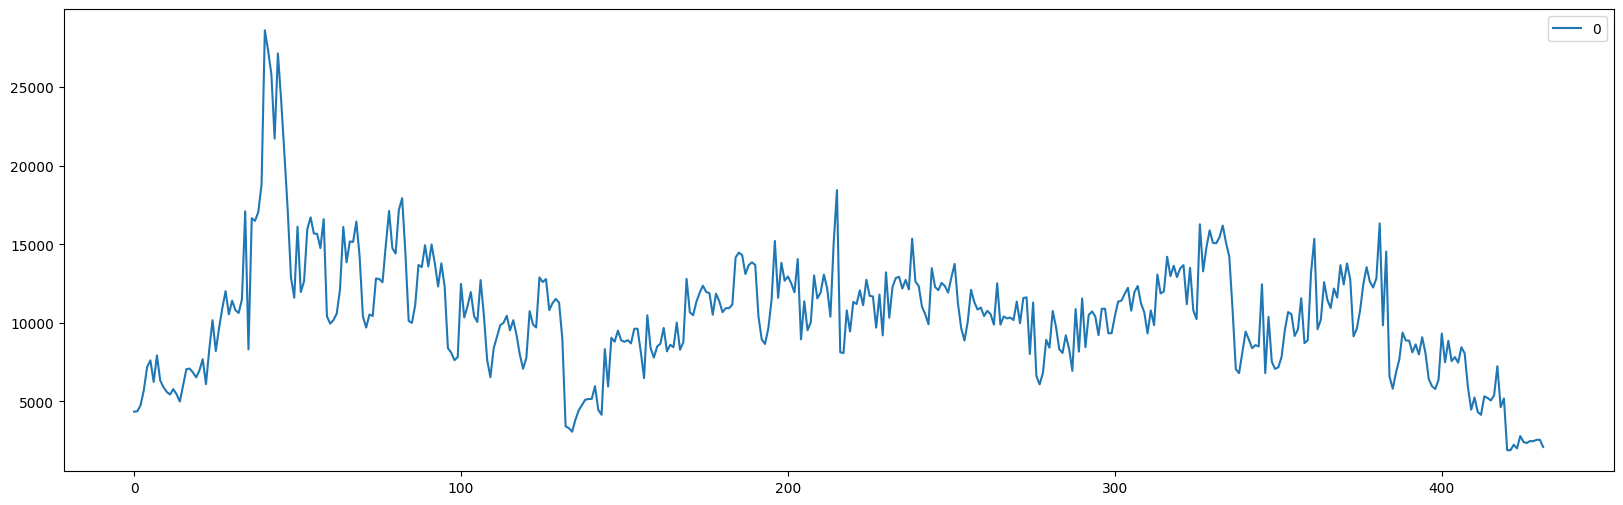

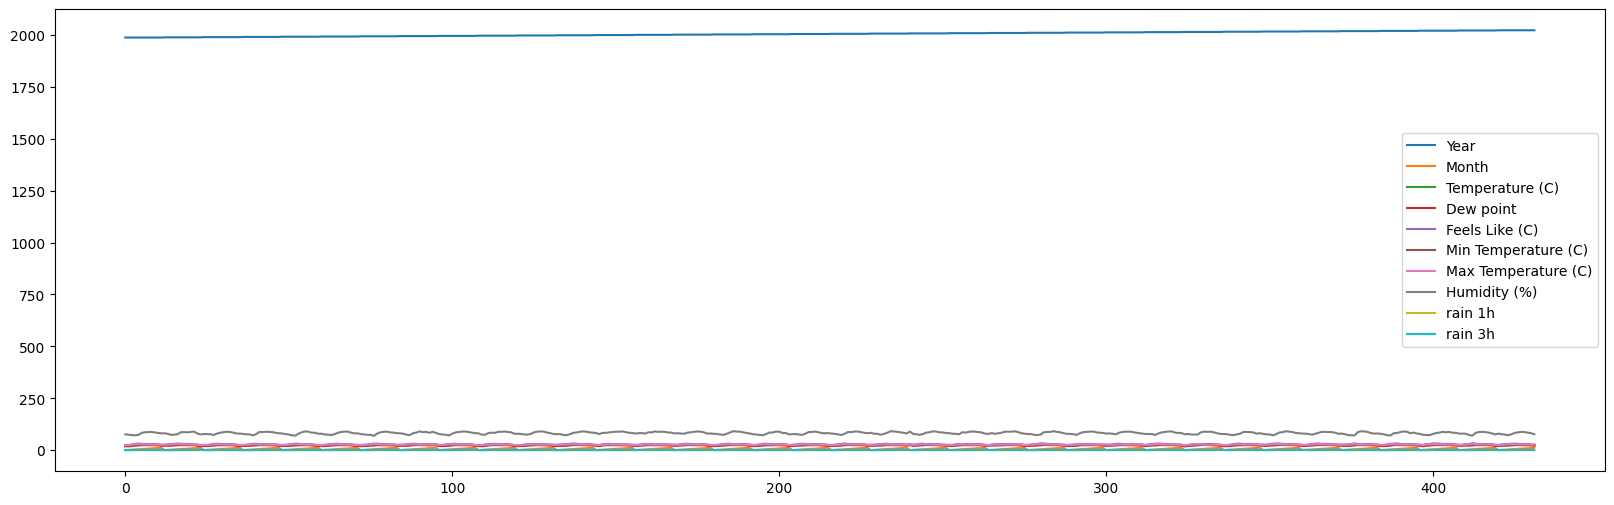

In [ ]:
import pandas as pd

# Read crop data
df = pd.read_csv('/content/drive/MyDrive/Research Model/df_ARIMA_final_allocation_new_test1.csv')
df.info()
df.plot(kind='line', figsize=(20, 6))

# Read weather data
df_weather = pd.read_csv('/content/drive/MyDrive/Research Model/weather data.csv')
df_weather.info()
df_weather.plot(kind='line', figsize=(20, 6))

In [ ]:
# CUT THE WEATHER DATA (:-36 to remove 3 years for testing)
df_weather = df_weather.iloc[:-36]

<Axes: >

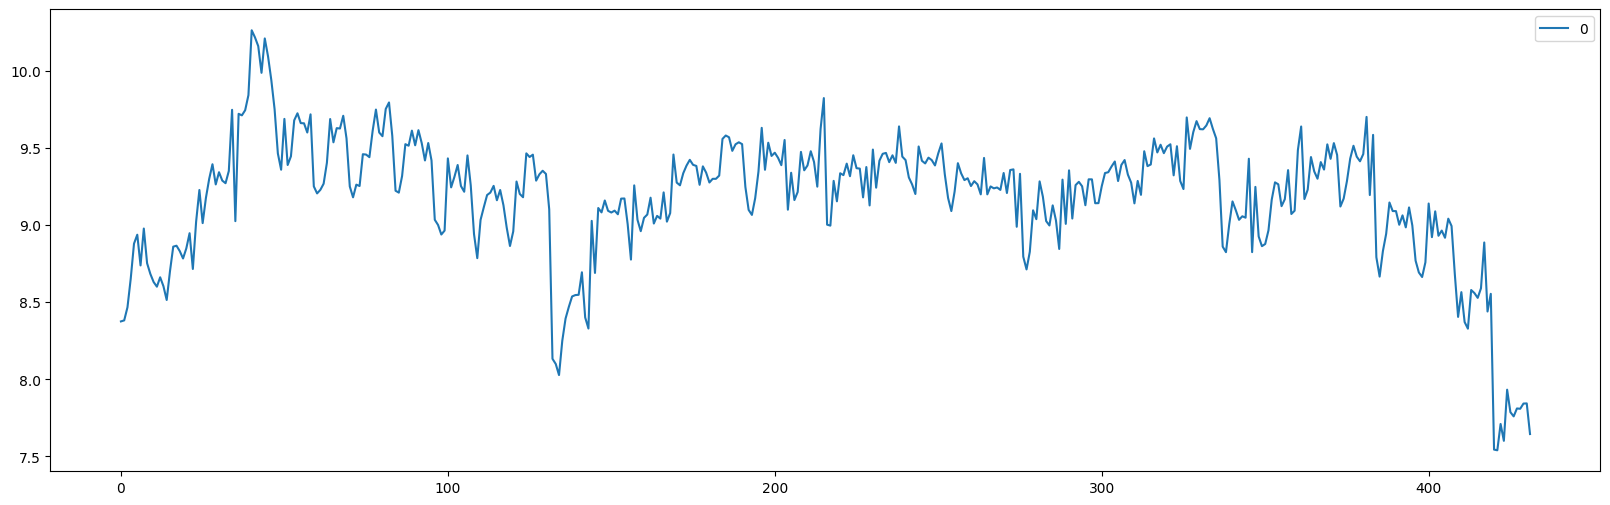

In [ ]:
# Logarithmic values
import numpy as np
df = np.log(df)
df.plot(kind='line', figsize=(20, 6))

In [ ]:
# Mask the data (Training | Testing)
msk = (df.index < len(df)-36)
df_train = df[msk].copy()
df_test  = df[~msk].copy()

training: 396
testing: 36


<Axes: >

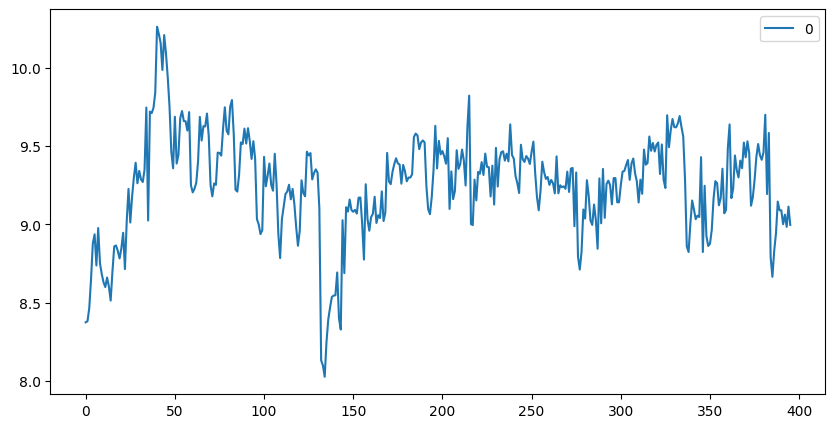

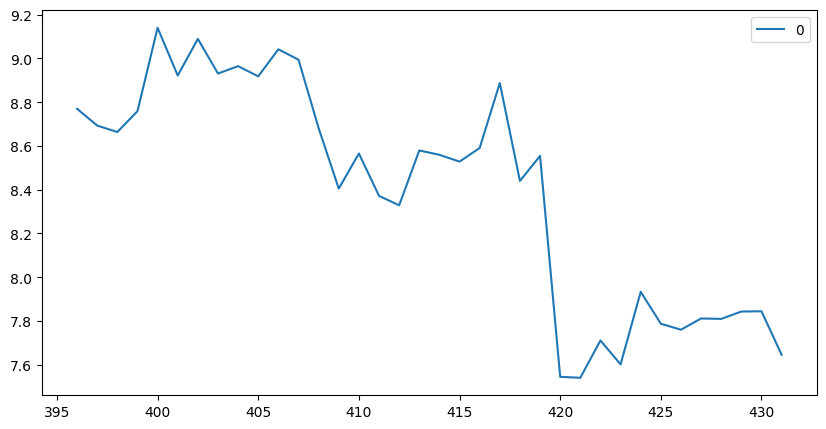

In [ ]:
# Data visualization (Training | Testing)
print('training:',len(df_train))
df_train.plot(figsize = (10,5))
print('testing:',len(df_test))
df_test.plot(figsize = (10,5))

#STEP 1: Check for stationary of Time Series

Method #1: time series plot

Method #2: ACF plot and PACF plot

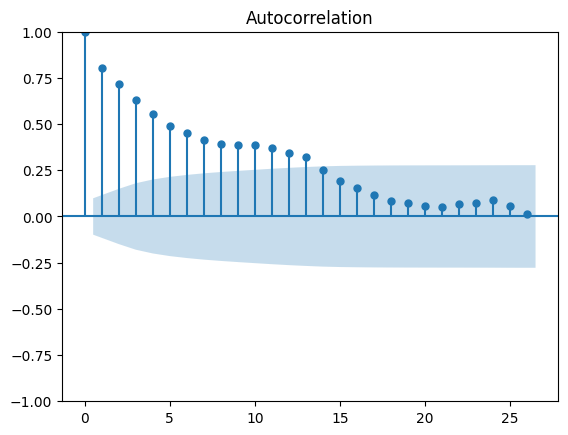

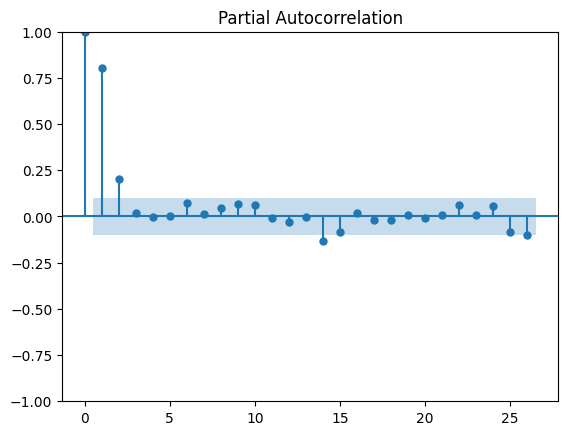

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

Method #3: ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)
print(f'p-value {adf_test[1]}')

p-value 5.901366625910456e-06


#Transform to stationary: differencing
Only use if p-value > 0.05

<Axes: >

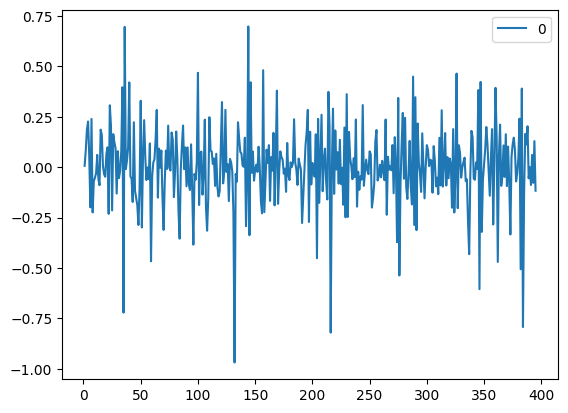

In [ ]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

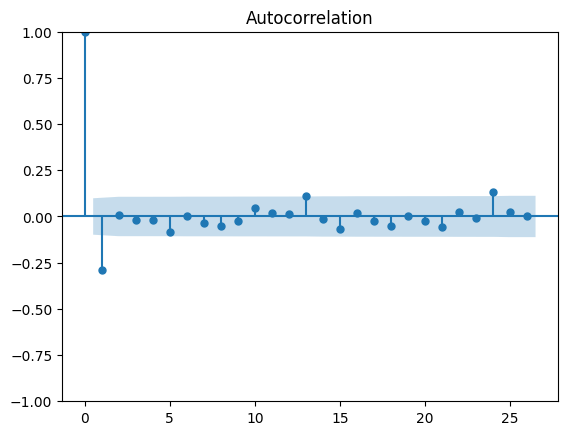

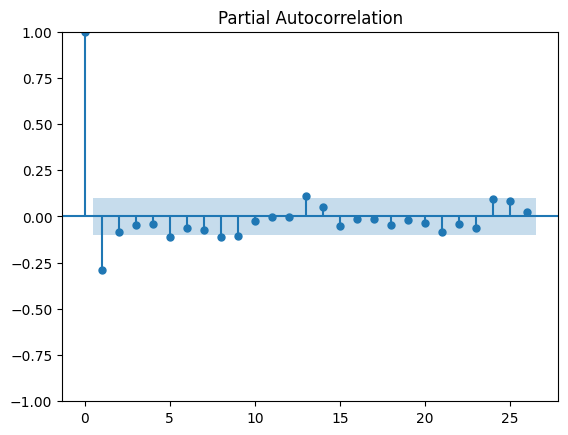

In [ ]:


acf_original = plot_acf(df_train_diff)
pacf_original = plot_pacf(df_train_diff)

In [ ]:
adf_test = adfuller(df_train_diff)
print(f'p-value {adf_test[1]}')

p-value 1.080931432183661e-16


#Step 2: Determine ARIMA

In [ ]:
pip install pmdarima

In [ ]:
# MANUAL SARIMA (determine p,d,q)
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(df_train, trace = True, supress_warnings = True, seasonal = True, m = 12, exog = df_weather[['Temperature (C)', 'Humidity (%)', 'rain 1h']])
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=9.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=232.976, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-191.703, Time=2.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-0.836, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2888.431, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-192.529, Time=0.67 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-191.452, Time=2.65 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=7.55 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-209.750, Time=1.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-210.077, Time=3.79 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-218.054, Time=13.54 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-196.613, Time=5.69 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  396
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                 115.516
Date:                             Mon, 04 Dec 2023   AIC                           -219.031
Time:                                     13:27:56   BIC                           -195.143
Sample:                                          0   HQIC                          -209.567
                                             - 396                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6004      0.153      3.931      0.000       0.301       0.900
ar.L1          0.9134      0.023     39.540      0.000       0.868       0.959
ma.L1         -0.3034      0.043     -7.096      0.000      -0.387      -0.220
ar.S.L12       0.0749      0.037      2.026      0.043       0.002       0.147
ar.S.L24       0.1719      0.042      4.108      0.000       0.090       0.254
sigma2         0.0325      0.002     21.429      0.000       0.030       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               216.03
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.60
Prob(H) (two-sided):                  0.72   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df_train, order = (1,0,1), seasonal_order=(1,0,0,12), exog = df_weather[['Temperature (C)', 'Humidity (%)', 'rain 1h']])
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   0   No. Observations:                  396
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                 328.385
Date:                             Mon, 04 Dec 2023   AIC                           -642.771
Time:                                     13:28:00   BIC                           -614.901
Sample:                                          0   HQIC                          -631.730
                                             - 396                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Temperature (C)     0.0306      0.005      6.350      0.000       0.021       0.040
Humidity (%)

#Step 4: Make time series predictions

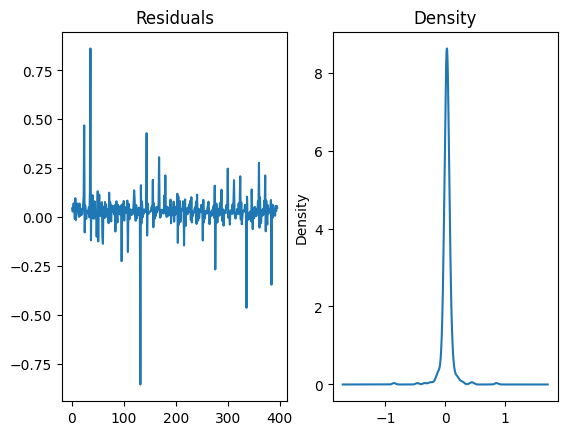

In [ ]:

import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

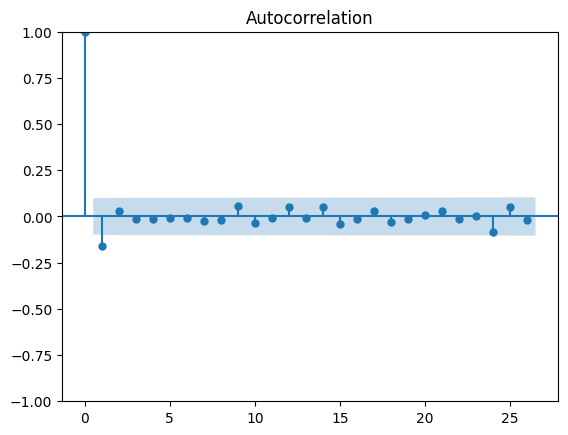

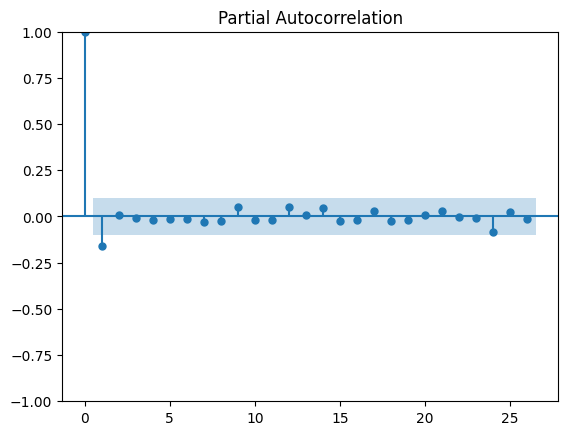

In [ ]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

In [ ]:
df_weather_test = df_weather.iloc[-36:]

In [ ]:
forecast_test = model_fit.forecast(steps=len(df_test), exog = df_weather_test[['Temperature (C)', 'Humidity (%)', 'rain 1h']])
forecast_test

396    9.291380
397    9.468647
398    8.888823
399    8.927354
400    9.170880
401    9.065971
402    8.977591
403    9.072735
404    8.978083
405    9.124900
406    8.943959
407    8.985547
408    8.729136
409    8.429626
410    8.444217
411    8.543714
412    8.718675
413    8.752675
414    8.672072
415    8.616392
416    8.635517
417    8.848511
418    8.320876
419    8.637979
420    8.236350
421    8.128477
422    8.239405
423    8.350791
424    8.504928
425    8.442355
426    8.404821
427    8.313989
428    8.328593
429    8.222766
430    8.299235
431    8.151744
Name: predicted_mean, dtype: float64

In [ ]:
df_train = df_train.rename(columns={'0': '1987 - 2019'})

# Assuming df_train and forecast_test are both Series
merged_data = pd.concat([df_train, forecast_test])

# If you want to reset the index, you can do:
merged_data.reset_index(drop=True, inplace=True)

# Now, merged_data contains both df_train and forecast_test
print(merged_data)

     1987 - 2019         0
0       8.375419       NaN
1       8.382054       NaN
2       8.466664       NaN
3       8.652860       NaN
4       8.879386       NaN
..           ...       ...
427          NaN  8.313989
428          NaN  8.328593
429          NaN  8.222766
430          NaN  8.299235
431          NaN  8.151744

[432 rows x 2 columns]


<Axes: >

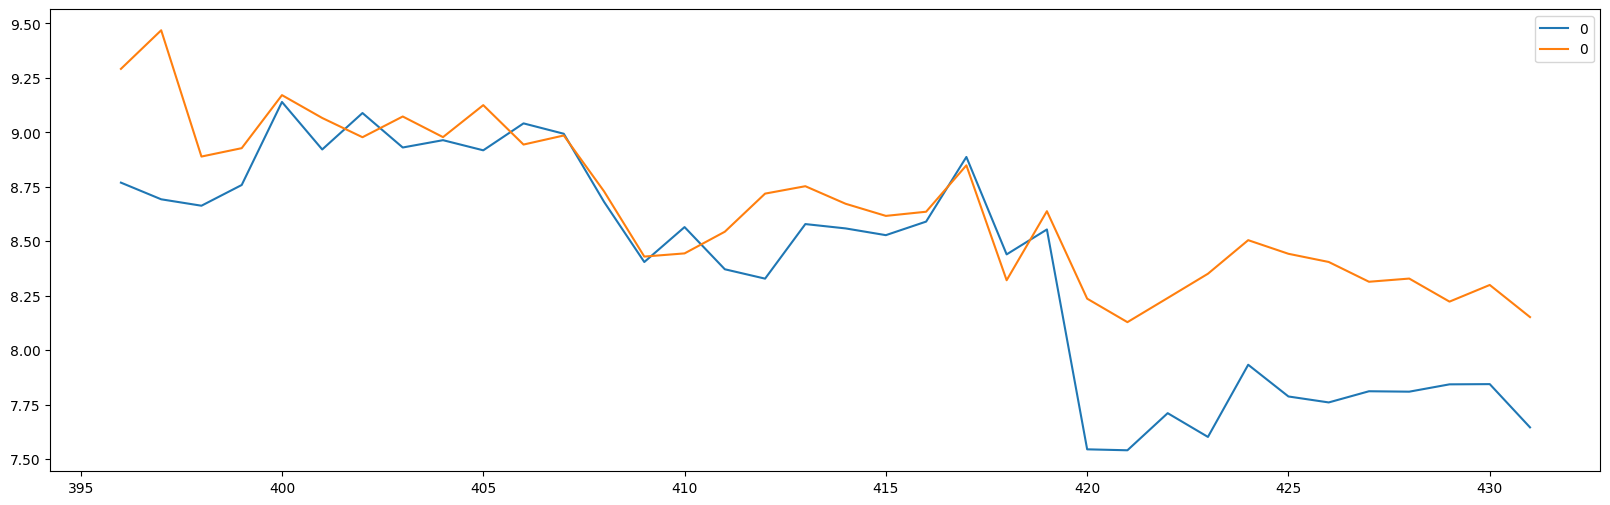

In [ ]:
# Plot original value and predicted test value (for comparison)
df_merged_data = pd.concat([df, forecast_test])
df_merged_data = df_merged_data.iloc[396:] # Get only the forecast point for graph

df_merged_data.plot(figsize=(20, 6))

In [ ]:
import pandas as pd
from scipy import stats

df_t_test = pd.concat([df.iloc[396:], forecast_test], axis=1)

In [ ]:
df_t_test

,0,predicted_mean
396,8.769108,9.291380
397,8.692582,9.468647
398,8.663104,8.888823
399,8.758257,8.927354
400,9.139427,9.170880
401,8.921426,9.065971
402,9.088657,8.977591
403,8.930442,9.072735
404,8.964038,8.978083
405,8.917521,9.124900


In [ ]:
# Perform the paired T-test
t_statistic, p_value = stats.ttest_rel(df_t_test['0'], df_t_test['predicted_mean'])

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -5.797727740258028
P-Value: 1.4264552638505855e-06


#Step 5: Evaluate model predictions

Mean Absolute Error

The Mean Absolute Error (MAE) is a common metric used to evaluate the accuracy of forecasts generated by time series models, including the Autoregressive Integrated Moving Average (ARIMA) model. MAE measures the average absolute difference between the actual observed values and the predicted values from the model.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

In [ ]:
# Un-log the value using the exponential function
df_test = np.exp(df_test)
forecast_test = np.exp(forecast_test)

In [ ]:
# MANUAL ARIMA
mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error (df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print( f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 1351.4371163745539
mape - manual: 0.3853509947326857
rmse - manual: 1859.8412940054732


#Predicting Future Values

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Research Model/df_ARIMA_final_allocation_new_test1.csv')
df_weather = pd.read_csv('/content/drive/MyDrive/Research Model/weather data.csv')
df_weather_predicted = pd.read_csv('/content/drive/MyDrive/Research Model/weather data [predicted].csv')

In [ ]:
model2 = SARIMAX(df, order = (1,0,1), seasonal_order = (1,0,0,12), exog = df_weather[['Temperature (C)', 'Humidity (%)', 'rain 1h']])
model2 = model2.fit()
df.tail

<bound method NDFrame.tail of                0
0    4339.085223
1    4367.972411
2    4753.632198
3    5726.501895
4    7182.377416
..           ...
427  2468.141024
428  2463.355924
429  2547.677819
430  2550.319435
431  2090.976469

[432 rows x 1 columns]>

In [ ]:
pred = model2.predict(start = len(df), end = len(df)+11, type = 'levels', exog = df_weather_predicted[['Temperature (C)', 'Humidity (%)', 'rain 1h']]).rename('SARIMAX Predictions')
print(pred)

432    2396.549388
433    1955.370825
434    2651.028207
435    3014.917186
436    5094.528569
437    4934.664761
438    5100.079237
439    4839.109865
440    5195.761998
441    5947.910564
442    4752.202487
443    4954.423502
Name: SARIMAX Predictions, dtype: float64


<Axes: >

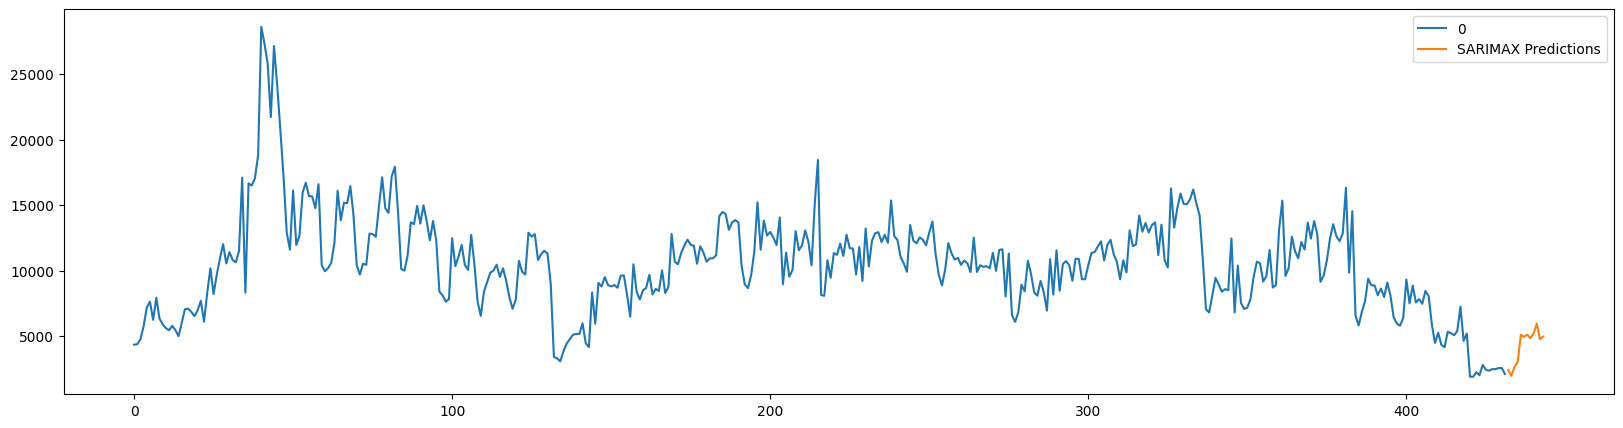

In [ ]:
df.plot()
pred.plot(figsize=(20,5), legend=True)

In [ ]:
pred

432    2396.549388
433    1955.370825
434    2651.028207
435    3014.917186
436    5094.528569
437    4934.664761
438    5100.079237
439    4839.109865
440    5195.761998
441    5947.910564
442    4752.202487
443    4954.423502
Name: SARIMAX Predictions, dtype: float64

In [ ]:
print("2023 Prediction for Rainfed Palay harvest (Nueva Ecija): ", pred.sum(), 'Hta')

2023 Prediction for Rainfed Palay harvest (Nueva Ecija):  50836.54658943924 Hta


#DATA VISUALIZATION (Compilation)

In [ ]:
# Set your start and end dates
start_date = '1987-01-01'
end_date = '2022-12-31'

# Create a date range using pd.date_range
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

            1987 - 2022
1987-01-31  4339.085223
1987-02-28  4367.972411
1987-03-31  4753.632198
1987-04-30  5726.501895
1987-05-31  7182.377416
...                 ...
2022-08-31  2468.141024
2022-09-30  2463.355924
2022-10-31  2547.677819
2022-11-30  2550.319435
2022-12-31  2090.976469

[432 rows x 1 columns]


<Axes: >

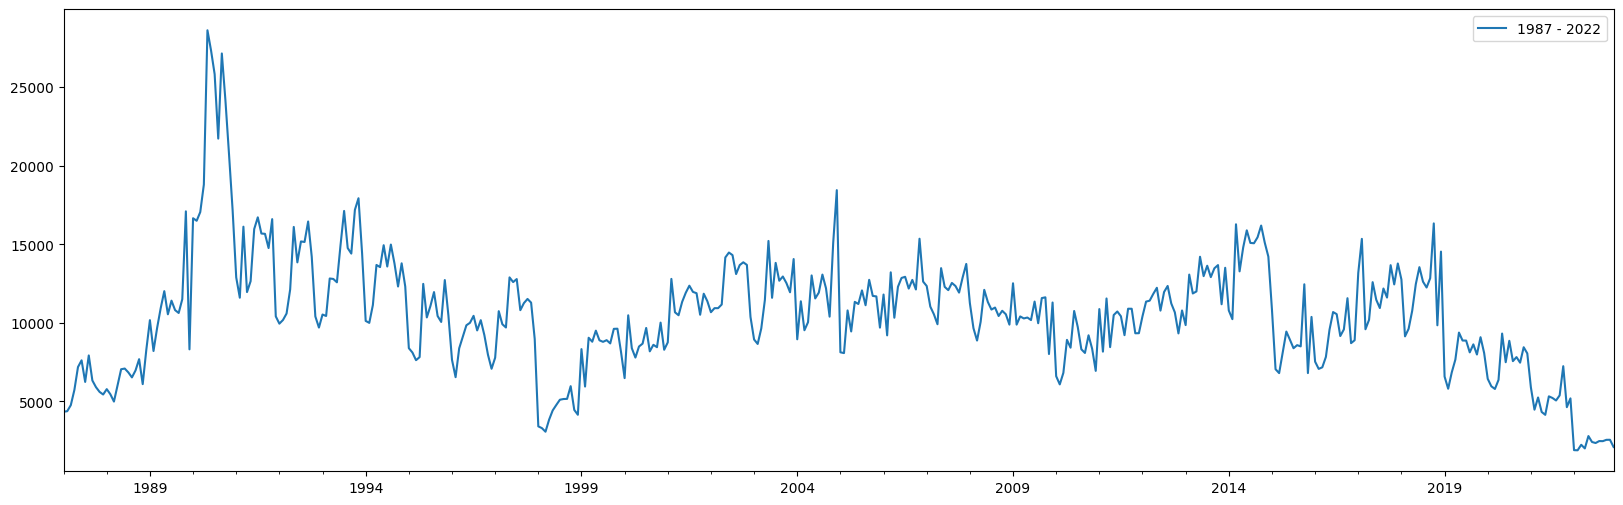

In [ ]:
# ORIGINAL DATA
df_visualization = df
df_visualization = df_visualization.rename(columns={'0': '1987 - 2022'})
df_visualization.index = date_range

print(df_visualization)
df_visualization.plot(figsize=(20, 6))

In [ ]:
# FORECAST (TEST)
merged_data_visualization = merged_data
merged_data_visualization.index = date_range

# Logarithmically transformed value
x_log = merged_data_visualization  # Replace with your actual log-transformed value

# Un-log the value using the exponential function
merged_data_visualization = np.exp(x_log)

print(merged_data_visualization)
merged_data_visualization.plot(figsize=(20, 6))

NameError: ignored

            1987 - 2022            0
2023-01-31          NaN  2396.549388
2023-02-28          NaN  1955.370825
2023-03-31          NaN  2651.028207
2023-04-30          NaN  3014.917186
2023-05-31          NaN  5094.528569
2023-06-30          NaN  4934.664761
2023-07-31          NaN  5100.079237
2023-08-31          NaN  4839.109865
2023-09-30          NaN  5195.761998
2023-10-31          NaN  5947.910564
2023-11-30          NaN  4752.202487
2023-12-31          NaN  4954.423502
2023 Prediction for Rainfed Palay harvest (Nueva Ecija):  50836.54658943924 Hta


<Axes: >

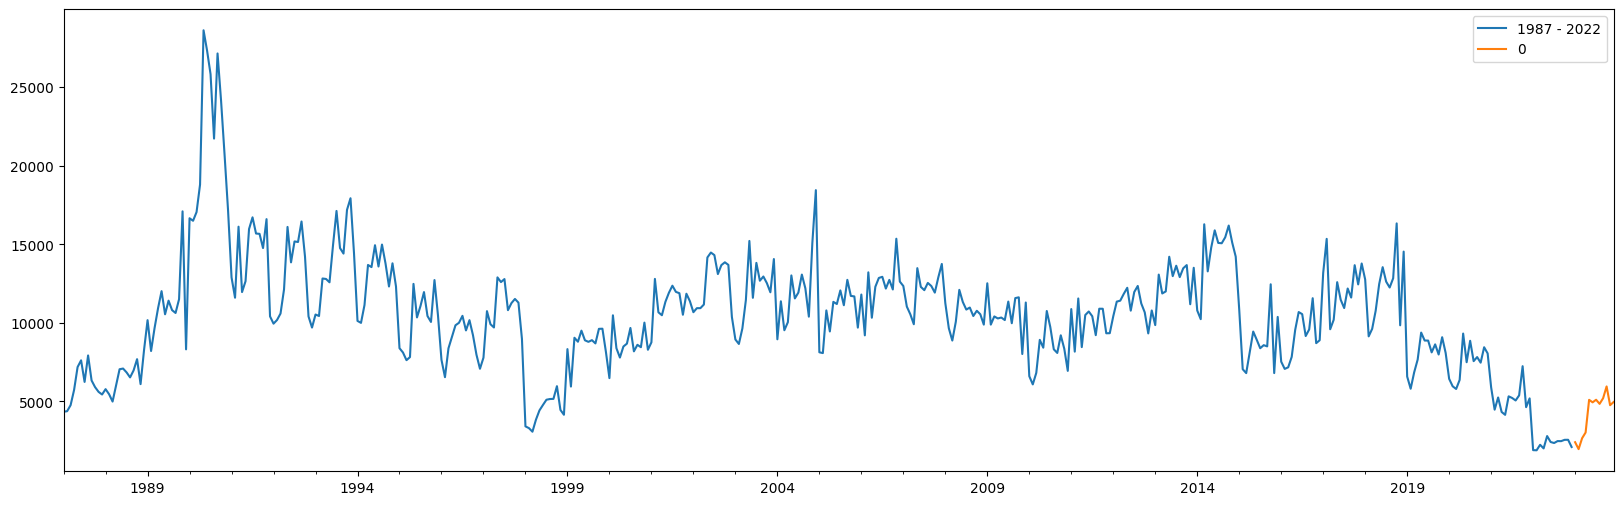

In [ ]:
# FORECAST DATA (2023)
# Set your start and end dates
start_date = '1987-01-01'
end_date = '2023-12-31'

# Create a date range using pd.date_range
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

df = df.rename(columns={'0': '1987 - 2022'})

# Assuming df_train and forecast_test are both Series
merged_data_prediction = pd.concat([df, pred])

# If you want to reset the index, you can do:
merged_data_prediction.reset_index(drop=True, inplace=True)

merged_data_prediction.index = date_range

print(merged_data_prediction.tail(12))
print("2023 Prediction for Rainfed Palay harvest (Nueva Ecija): ", pred.sum(), 'Hta')
merged_data_prediction.plot(figsize=(20, 6))